In [1]:
# paramter cell do not remove!!
# nb_parm='datalake|raw/pdf|Birddiversityanddistribution|pdf||300|150'
# nb_parm='datalake|raw/text-csv|PFW_spp_translation_table_May2024|csv||300|150'
nb_parm='llmnok'
question = 'how many bird species are in migratory?'
embed_model = "mxbai-embed-large" 
gen_model = "deepseek-r1:7b"
# collection = "Bridknowledge"

In [2]:
import sys
import os

sys.path.append("/home/jovyan/notebooks")
from Framework.module import Utility

## Do the task after this

In [3]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
import importlib
import inspect
from importlib import import_module
from langchain_core.tools import BaseTool
from email.message import EmailMessage
from typing import List
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
import smtplib

def load_all_tools(module_path: str):
    """
    Load all @tool-decorated functions from a module.

    Args:
        module_path (str): Python module path like 'tools'

    Returns:
        List of tool function objects
    """
    tools = []
    module = import_module(module_path)
    for name, obj in inspect.getmembers(module):
        if isinstance(obj, BaseTool):
            tools.append(obj)
    return tools
    
utility_tools = load_all_tools("Framework.pool_of_tools")
basetools = load_all_tools("Framework.base_tools")


llm = ChatOllama(
    model="llama3-groq-tool-use:8b",
    temperature=0,
    base_url="http://host.docker.internal:11434"
)

# Augment the LLM with tools
tools = utility_tools + basetools
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from typing_extensions import Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        # content="You are a helpful assistant. You can call tools to perform tasks such as: Validating users (user ID and addresses), Sending emails via Gmail (with subject/body/from email/password) and Math operations like add, multiply, divide."
                        content="You are a helpful assistant. You can call tools to perform tasks and success it accroding to user prompt"

                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
        
    # print("tool_node", result)
    return {"messages": result}

  

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()


In [5]:
# # Show the agent
# display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# # Invoke
# # messages = [HumanMessage(content="Could you validate user 123? Thet previously lived at 123 Fake st in boston MA and 234 Pretend Boulevard in Houston TX. Then Send an email to nattapat.7140@gmail.com saying 'Hi Best, hope you're doing well. Just checking in!' with subject from user validation result. Use sender email nattapat.0645@gmail.com and app password a0645402317. ")]
# messages = [HumanMessage(content=
#                          """Validate user 123 with these addresses:
#                             - 123 Fake st in Boston, MA
#                             - 234 Pretend Boulevard in Houston, TX
#                             Then keep result
#                             Then send_gmail_email_llm to nattapat.7140@gmail.com with:
#                             Subject: User Validation Result
#                             Body: Hi Best, here validation result {result}
#                             Sender: nattapat.0645@gmail.com
#                             Password: a0645402317 
#                          """)]


# messages = agent.invoke({"messages": messages})
# for m in messages["messages"]:
#     m.pretty_print()

## Run another agent

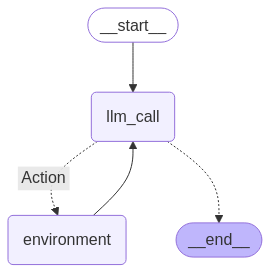

/opt/conda/lib/python3.11/site-packages/ollama/_types.py:81: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  if key in self.model_fields:
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:82: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields[key].default is not None
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:81: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  if key in self.model_fields:
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:82: 

Error: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d2e1a72fcca58-73dbfa58376sm6623863b3a.100 - gsmtp')
================================ Human Message =================================


 generate sql script for select all of data from table EDP.TEST1
 Then keep a result send_google_email to nattapat.7140@gmail.com with:
    Subject: SQL output
    Body: Hi Best, here the result from generation {generate_sql.result}
    Sender: nattapat.0645@gmail.com
    Password: a0645402317 
 
================================== Ai Message ==================================
Tool Calls:
  generate_sql (b06476ce-5ef0-4be4-b009-b4f0967d2ae0)
 Call ID: b06476ce-5ef0-4be4-b009-b4f0967d2ae0
  Args:
    content: SELECT * FROM EDP.TEST1
================================= Tool Message =================================

{'result': 'SELECT * FROM EDP.TEST1'}
================================== Ai Message ===================

/opt/conda/lib/python3.11/site-packages/ollama/_types.py:81: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  if key in self.model_fields:
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:82: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields[key].default is not None


In [6]:
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
# messages = [HumanMessage(content="Could you validate user 123? Thet previously lived at 123 Fake st in boston MA and 234 Pretend Boulevard in Houston TX. Then Send an email to nattapat.7140@gmail.com saying 'Hi Best, hope you're doing well. Just checking in!' with subject from user validation result. Use sender email nattapat.0645@gmail.com and app password a0645402317. ")]
messages = [HumanMessage(content=
 """
 generate sql script for select all of data from table EDP.TEST1
 Then keep a result send_google_email to nattapat.7140@gmail.com with:
    Subject: SQL output
    Body: Hi Best, here the result from generation {generate_sql.result}
    Sender: nattapat.0645@gmail.com
    Password: a0645402317 
 """)]


messages = agent.invoke({"messages": messages})
for m in messages["messages"]:                                                                              
    m.pretty_print()